# Installing packages

In [2]:
!pip install --upgrade pip
!pip install deeppavlov
!python -m deeppavlov install squad_bert
!pip uninstall tensorflow
!pip install tensorflow-gpu==1.15.2
!pip install transformers==2.8.0

2021-03-05 08:52:29.951 INFO in 'deeppavlov.core.common.file'['file'] at line 32: Interpreting 'squad_bert' as '/usr/local/lib/python3.7/dist-packages/deeppavlov/configs/squad/squad_bert.json'
  Cloning https://github.com/deepmipt/bert.git (to revision feat/multi_gpu) to /tmp/pip-req-build-fmxrmyrj
  Running command git clone -q https://github.com/deepmipt/bert.git /tmp/pip-req-build-fmxrmyrj
2021-03-05 08:52:34.761 WARNING in 'deeppavlov.utils.pip_wrapper.pip_wrapper'['pip_wrapper'] at line 34: found tensorflow-gpu installed, so upgrading it instead of tensorflow


Make sure tensorflow can see GPU

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("="*100)
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print("="*100)
from tensorflow.python.client import device_lib
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
get_available_gpus()

Num GPUs Available:  0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18190045266778125332
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 13590889466303357453
physical_device_desc: "device: XLA_CPU device"
]


[]

# Imports

In [3]:
from deeppavlov.core.data.utils import download
from deeppavlov.dataset_readers.basic_classification_reader import BasicClassificationDatasetReader
from deeppavlov.dataset_iterators.basic_classification_iterator import BasicClassificationDatasetIterator

from deeppavlov.models.preprocessors.bert_preprocessor import BertPreprocessor
from deeppavlov.models.preprocessors.torch_transformers_preprocessor import TorchTransformersPreprocessor

from deeppavlov.core.data.simple_vocab import SimpleVocabulary
from deeppavlov.models.preprocessors.one_hotter import OneHotter
from deeppavlov.models.classifiers.proba2labels import Proba2Labels
from deeppavlov.models.bert.bert_classifier import BertClassifierModel
from deeppavlov.metrics.accuracy import sets_accuracy
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from tqdm import tqdm
prob2labels = Proba2Labels(max_proba=True)

import pandas as pd
from sklearn.model_selection import train_test_split
import os
import random

import numpy as np
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package perluniprops to /root/nltk_data...
[nltk_data]   Unzipping misc/perluniprops.zip.
[nltk_data] Downloading package nonbreaking_prefixes to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping corpora/nonbreaking_prefixes.zip.


# Get and adjust data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv("/content/drive/MyDrive/colab_files/Publication_v1/sensitive/train.csv")
df_val = pd.read_csv("/content/drive/MyDrive/colab_files/Publication_v1/sensitive/val.csv")
df_test = pd.read_csv("/content/drive/MyDrive/colab_files/Publication_v1/sensitive/test.csv")

# df = pd.read_csv("train.csv")
# df_val = pd.read_csv("val.csv")
# df_test = pd.read_csv("test.csv")


In [6]:
df.columns

Index(['text', 'offline_crime', 'online_crime', 'drugs', 'gambling',
       'pornography', 'prostitution', 'slavery', 'suicide', 'terrorism',
       'weapons', 'body_shaming', 'health_shaming', 'politics', 'racism',
       'religion', 'sexual_minorities', 'sexism', 'social_injustice'],
      dtype='object')

In [7]:
columns = list(df.columns)[1:] 
train_labels =[]
for i, el in df.iterrows():
  current_sample_labels = []
  any_class = False
  for clm in columns:
    if el[clm] == 1:
      any_class = True
      current_sample_labels.append(clm)
  if any_class == False:
    current_sample_labels.append("none")
  current_sample_labels = ','.join(current_sample_labels)
  train_labels.append(current_sample_labels)

val_labels =[]
for i, el in df_val.iterrows():
  current_sample_labels = []
  any_class = False
  for clm in columns:
    if el[clm] == 1:
      any_class = True
      current_sample_labels.append(clm)
  if any_class == False:
    current_sample_labels.append("none")
  current_sample_labels = ','.join(current_sample_labels)
  val_labels.append(current_sample_labels)


test_labels =[]
for i, el in df_test.iterrows():
  current_sample_labels = []
  any_class = False
  for clm in columns:
    if el[clm] == 1:
      any_class = True
      current_sample_labels.append(clm)
  if any_class == False:
    current_sample_labels.append("none")
  current_sample_labels = ','.join(current_sample_labels)
  test_labels.append(current_sample_labels)


In [8]:
df_train_adjusted = pd.DataFrame({'text':list(df['text']), 'labels':train_labels})
df_val_adjusted = pd.DataFrame({'text':list(df_val['text']), 'labels':val_labels})
df_test_adjusted = pd.DataFrame({'text':list(df_test['text']), 'labels':test_labels})

In [9]:
df_train_adjusted.head()

,text,labels
0,"ахахахахахаМое лицо когда ты думаешь, что тебя...",offline_crime
1,Стать правителем и посадить их всех в тюрьму. ...,offline_crime
2,можно было сократить - убить всех долбоёбов,offline_crime
3,"Надо сделать справедливо, и за износ наказыват...",offline_crime
4,"Можете указывать, что несудимы, и устраиваться...",offline_crime


In [10]:
!mkdir data_multilabel

In [11]:
df_train_adjusted.to_csv("./data_multilabel/train.csv", sep = ',', index = None)
df_val_adjusted.to_csv("./data_multilabel/val.csv", sep = ',', index = None)
df_test_adjusted.to_csv("./data_multilabel/test.csv", sep = ',', index = None)

In [12]:
len(df_train_adjusted), len(df_val_adjusted),  len(df_val_adjusted)

(23183, 1174, 1174)

In [13]:
reader = BasicClassificationDatasetReader()
data = reader.read(data_path="./data_multilabel", 
                   train="train.csv", valid="val.csv", test = "test.csv",
                   x="text", y="labels")

In [14]:
iterator = BasicClassificationDatasetIterator(data, shuffle=True)

# Prepare model

In [15]:
# !wget http://files.deeppavlov.ai/deeppavlov_data/bert/ru_conversational_cased_L-12_H-768_A-12.tar.gz
!cp /content/drive/MyDrive/colab_files/ru_conversational_cased_L-12_H-768_A-12.tar.gz ru_conversational_cased_L-12_H-768_A-12.tar.gz 
!tar -xf ru_conversational_cased_L-12_H-768_A-12.tar.gz

In [16]:
PRETR_BERT_PATH = "./ru_conversational_cased_L-12_H-768_A-12"

In [17]:
bert_preprocessor = BertPreprocessor(vocab_file=os.path.join(PRETR_BERT_PATH,"vocab.txt"),
                                     do_lower_case=False,
                                     max_seq_length=256)

In [18]:
input_features = bert_preprocessor(["мама мыла раму"])
print(input_features[0].tokens)
print(input_features[0].input_ids)
print(input_features[0].input_mask)
print(input_features[0].input_type_ids)

['[CLS]', 'мама', 'мыла', 'раму', '[SEP]']
[101, 4775, 49053, 53954, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [19]:
vocab = SimpleVocabulary(save_path="./binary_classes.dict")

2021-03-05 09:00:26.97 WARNING in 'deeppavlov.core.models.serializable'['serializable'] at line 49: No load path is set for SimpleVocabulary in 'infer' mode. Using save path instead


In [20]:
vocab.fit(iterator.get_instances(data_type="train")[1])

In [21]:
target_vaiables = list(vocab.items())
target_vaiables_id2topic_dict = {el2:el1 for el1,el2 in target_vaiables}

In [22]:
one_hotter = OneHotter(depth=vocab.len, 
                       single_vector=True
                      )

In [23]:
vocab.len

391

In [24]:
bert_classifier = BertClassifierModel(
    multilabel = True,
    n_classes=vocab.len,
    return_probas=True,
    one_hot_labels=True,
    bert_config_file=os.path.join(PRETR_BERT_PATH,"bert_config.json"),
    pretrained_bert=os.path.join(PRETR_BERT_PATH,"bert_model.ckpt"),
    save_path="/content/drive/MyDrive/colab_files/Publication_v1/sensitive/sensitive_model_v1/model",
    load_path="/content/drive/MyDrive/colab_files/Publication_v1/sensitive/sensitive_model_v1/model",
    keep_prob=0.5,
    learning_rate=1e-05,
    learning_rate_drop_patience=5,
    learning_rate_drop_div=2.0
)







The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




Instructions for updating:
Use standard file APIs to check for files with this prefix.


2021-03-05 09:00:54.32 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 51: [loading model from /content/drive/MyDrive/colab_files/Publication_v1/sensitive/sensitive_model_v1/model]



INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/colab_files/Publication_v1/sensitive/sensitive_model_v1/model


# Set validation functions

In [25]:
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
import random

In [26]:
topics_list = list(df.columns)[1:] + ['none']

In [27]:
def adjust_multilabel(y, is_pred = False):
    y_adjusted = []
    for y_c in y:
      y_test_curr = [0]*19
      if is_pred == True:
        y_c = target_vaiables_id2topic_dict[np.argmax(y_c)]
      for tag in y_c.split(","):
        topic_index = topics_list.index(tag)
        y_test_curr[topic_index] = 1
      y_adjusted.append(y_test_curr)
    return y_adjusted

def get_metrics(y_test,y_pred_tag, for_classifier = True):

    y_test = adjust_multilabel(y_test)
    y_test = np.array(y_test)

    y_pred_tag = adjust_multilabel(y_pred_tag, is_pred = True)
    y_pred_tag = np.array(y_pred_tag)

    spl = random.randint(1,1000)

    print("y_test", y_test.shape)
    print("y_test\n", y_test[spl:spl+10])
    
    print("y_pred_tag",y_pred_tag.shape)
    print("y_pred_tag\n", y_pred_tag[spl:spl+10])

    for f1_type in ['macro','weighted']:
        curr_type_f1 = f1_score(y_test, y_pred_tag, average = f1_type)
        print("f1 type {} value is {}".format(f1_type, round(curr_type_f1,2)))
    
    if for_classifier == True:
        average = 'macro'
    else:
        average = None
    f1 = f1_score(y_test, y_pred_tag, average = average)# average = 'macro'
    return f1 


Start training


Train: 100%|█████████▉| 1447/1448 [12:43<00:00,  1.90it/s, epoch=0, loss=0.00241]

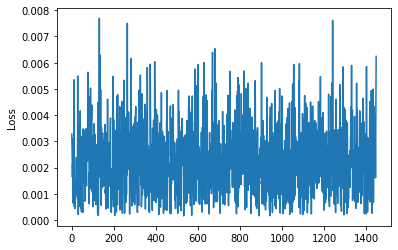

Train: 1449it [12:44,  1.74it/s, epoch=0, loss=0.00245]                          
valid:   0%|          | 0/73 [00:00<?, ?it/s]

validating .... 



valid: 100%|██████████| 73/73 [00:14<00:00,  5.46it/s]2021-03-05 04:57:54.224 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /content/drive/MyDrive/colab_files/Publication_v1/sensitive/sensitive_model_v1/model]


y_test (1174, 19)
y_test
 [[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]]
y_pred_tag (1174, 19)
y_pred_tag
 [[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]]
f1 type macro value is 0.59
f1 type weighted value is 0.62
macro 0.5864871852867889
Epochs done: 1. Valid macro: 0.586

Train:   0%|          | 0/1448 [00:00<?, ?it/s]

New best score. Saving model.


Train: 100%|█████████▉| 1447/1448 [12:42<00:00,  1.88it/s, epoch=1, loss=0.00229]

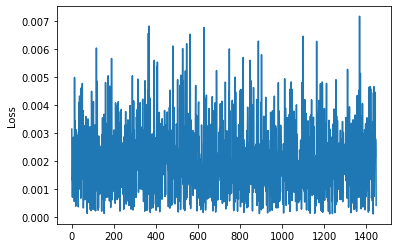

Train: 1449it [12:43,  1.79it/s, epoch=1, loss=0.00225]                          
valid: 74it [13:03, 10.58s/it]                        

Train: 1449it [25:47,  1.07s/it, epoch=0, loss=0.00245]
valid:   1%|▏         | 1/73 [00:00<00:13,  5.21it/s]

validating .... 


valid: 100%|██████████| 73/73 [00:12<00:00,  5.70it/s]2021-03-05 05:10:55.995 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /content/drive/MyDrive/colab_files/Publication_v1/sensitive/sensitive_model_v1/model]


y_test (1174, 19)
y_test
 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0]]
y_pred_tag (1174, 19)
y_pred_tag
 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]]
f1 type macro value is 0.62
f1 type weighted value is 0.65
macro 0.6191292095673152
Epochs done: 2. Valid macro: 0.619

Train: 1449it [13:01,  1.85it/s, epoch=1, loss=0.00225]

New best score. Saving model.



Train: 100%|█████████▉| 1447/1448 [12:43<00:00,  1.90it/s, epoch=2, loss=0.00189]

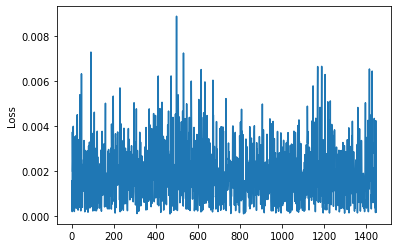

Train: 1449it [12:44,  1.80it/s, epoch=2, loss=0.0019]                          
valid:   0%|          | 0/73 [00:00<?, ?it/s]
valid: 74it [13:02, 10.57s/it]                        
valid:   1%|▏         | 1/73 [00:00<00:14,  5.02it/s]

validating .... 


Train: 1449it [12:57,  1.86it/s, epoch=2, loss=0.0019]


y_test (1174, 19)
y_test
 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0]]
y_pred_tag (1174, 19)
y_pred_tag
 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]]
f1 type macro value is 0.6
f1 type weighted value is 0.63
macro 0.6030110879356306
Epochs done: 3. Valid macro: 0.6030

Train: 100%|█████████▉| 1447/1448 [12:44<00:00,  1.89it/s, epoch=3, loss=0.00189]

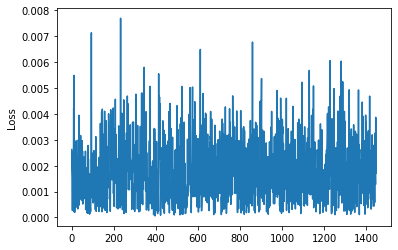

Train: 1449it [12:45,  1.78it/s, epoch=3, loss=0.00187]                          
valid:   0%|          | 0/73 [00:00<?, ?it/s]
valid: 74it [12:58, 10.52s/it]                        
valid:   1%|▏         | 1/73 [00:00<00:14,  4.91it/s]

validating .... 


Train:   0%|          | 0/1448 [00:00<?, ?it/s]

y_test (1174, 19)
y_test
 [[0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0]
 [1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0]]
y_pred_tag (1174, 19)
y_pred_tag
 [[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0]]
f1 type macro value is 0.61
f1 type weighted value is 0.64
macro 0.6109098843591102
Epochs done: 4. Valid macro: 0.610

Train: 100%|█████████▉| 1447/1448 [12:45<00:00,  1.89it/s, epoch=4, loss=0.00166]

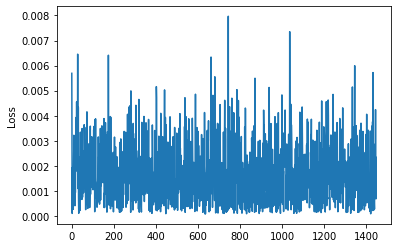

Train: 1449it [12:46,  1.77it/s, epoch=4, loss=0.00168]                          
valid:   0%|          | 0/73 [00:00<?, ?it/s]
valid: 74it [12:59, 10.53s/it]                        
Train: 1449it [25:44,  1.07s/it, epoch=3, loss=0.00187]
valid:   1%|▏         | 1/73 [00:00<00:14,  5.05it/s]

validating .... 


Train: 1449it [12:59,  1.86it/s, epoch=4, loss=0.00168]


y_test (1174, 19)
y_test
 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]]
y_pred_tag (1174, 19)
y_pred_tag
 [[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]]
f1 type macro value is 0.61
f1 type weighted value is 0.65
macro 0.6125156402795355
Epochs done: 5. Valid macro: 0.612

Train: 100%|█████████▉| 1447/1448 [12:44<00:00,  1.89it/s, epoch=5, loss=0.00145]

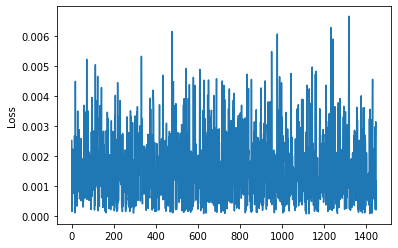

Train: 1449it [12:45,  1.79it/s, epoch=5, loss=0.00144]                          
valid:   0%|          | 0/73 [00:00<?, ?it/s]
valid: 74it [12:58, 10.52s/it]                        
valid:   1%|▏         | 1/73 [00:00<00:13,  5.19it/s]

validating .... 


valid: 100%|██████████| 73/73 [00:12<00:00,  5.70it/s]2021-03-05 06:02:55.165 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /content/drive/MyDrive/colab_files/Publication_v1/sensitive/sensitive_model_v1/model]


y_test (1174, 19)
y_test
 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]]
y_pred_tag (1174, 19)
y_pred_tag
 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]]
f1 type macro value is 0.64
f1 type weighted value is 0.67
macro 0.6379172059396927
Epochs done: 6. Valid macro: 0.637

Train:   0%|          | 0/1448 [00:00<?, ?it/s]

New best score. Saving model.


Train: 100%|█████████▉| 1447/1448 [12:43<00:00,  1.88it/s, epoch=6, loss=0.00151]

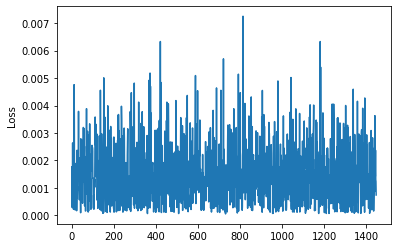

Train: 1449it [12:45,  1.78it/s, epoch=6, loss=0.00151]                          
valid:   0%|          | 0/73 [00:00<?, ?it/s]
valid: 74it [13:02, 10.58s/it]                        
Train: 1449it [25:48,  1.07s/it, epoch=5, loss=0.00144]
valid:   1%|▏         | 1/73 [00:00<00:15,  4.65it/s]

validating .... 


Train:   0%|          | 0/1448 [00:00<?, ?it/s]

y_test (1174, 19)
y_test
 [[0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0]]
y_pred_tag (1174, 19)
y_pred_tag
 [[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]]
f1 type macro value is 0.64
f1 type weighted value is 0.66
macro 0.6360381587982261
Epochs done: 7. Valid macro: 0.636

Train: 100%|█████████▉| 1447/1448 [12:45<00:00,  1.90it/s, epoch=7, loss=0.00143]

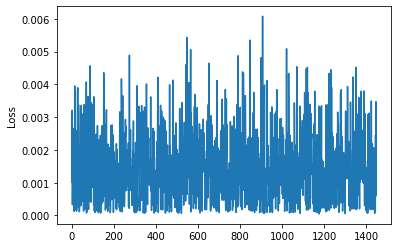

Train: 1449it [12:46,  1.80it/s, epoch=7, loss=0.00148]                          
valid:   0%|          | 0/73 [00:00<?, ?it/s]
valid: 74it [12:59, 10.53s/it]                        
Train: 1449it [25:44,  1.07s/it, epoch=6, loss=0.00151]
valid:   1%|▏         | 1/73 [00:00<00:13,  5.14it/s]

validating .... 


Train:   0%|          | 0/1448 [00:00<?, ?it/s]

y_test (1174, 19)
y_test
 [[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]]
y_pred_tag (1174, 19)
y_pred_tag
 [[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
f1 type macro value is 0.63
f1 type weighted value is 0.65
macro 0.6344173238414058
Epochs done: 8. Valid macro: 0.634

Train: 100%|█████████▉| 1447/1448 [12:47<00:00,  1.88it/s, epoch=8, loss=0.0014]

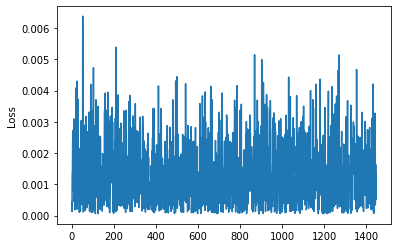

Train: 1449it [12:48,  1.77it/s, epoch=8, loss=0.00138]                          
valid:   0%|          | 0/73 [00:00<?, ?it/s]
valid: 74it [13:01, 10.56s/it]                        
Train: 1449it [25:47,  1.07s/it, epoch=7, loss=0.00148]
valid:   1%|▏         | 1/73 [00:00<00:14,  5.06it/s]

validating .... 


Train:   0%|          | 0/1448 [00:00<?, ?it/s]

y_test (1174, 19)
y_test
 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]]
y_pred_tag (1174, 19)
y_pred_tag
 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]]
f1 type macro value is 0.62
f1 type weighted value is 0.65
macro 0.6205589399615139
Epochs done: 9. Valid macro: 0.620

Train: 100%|█████████▉| 1447/1448 [12:48<00:00,  1.88it/s, epoch=9, loss=0.00134]

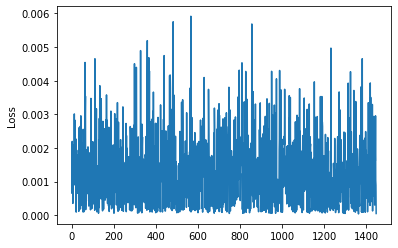

Train: 1449it [12:49,  1.77it/s, epoch=9, loss=0.00138]                          
valid:   0%|          | 0/73 [00:00<?, ?it/s]
valid: 74it [13:03, 10.58s/it]                        
Train: 1449it [25:51,  1.07s/it, epoch=8, loss=0.00138]
valid:   1%|▏         | 1/73 [00:00<00:15,  4.78it/s]

validating .... 


valid: 100%|██████████| 73/73 [00:13<00:00,  5.68it/s]2021-03-05 06:55:01.848 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /content/drive/MyDrive/colab_files/Publication_v1/sensitive/sensitive_model_v1/model]


y_test (1174, 19)
y_test
 [[1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0]]
y_pred_tag (1174, 19)
y_pred_tag
 [[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]]
f1 type macro value is 0.64
f1 type weighted value is 0.66
macro 0.6392270386820126
Epochs done: 10. Valid macro: 0.63

Train:   0%|          | 0/1448 [00:00<?, ?it/s]

New best score. Saving model.


Train: 100%|█████████▉| 1447/1448 [12:50<00:00,  1.87it/s, epoch=10, loss=0.00119]

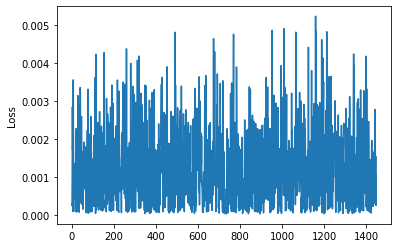

Train: 1449it [12:51,  1.59it/s, epoch=10, loss=0.00119]                          
valid:   0%|          | 0/73 [00:00<?, ?it/s]
valid: 74it [13:09, 10.68s/it]                        
Train: 1449it [25:59,  1.08s/it, epoch=9, loss=0.00138]
valid:   1%|▏         | 1/73 [00:00<00:15,  4.78it/s]

validating .... 


valid: 100%|██████████| 73/73 [00:13<00:00,  5.52it/s]2021-03-05 07:08:11.886 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /content/drive/MyDrive/colab_files/Publication_v1/sensitive/sensitive_model_v1/model]


y_test (1174, 19)
y_test
 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0]]
y_pred_tag (1174, 19)
y_pred_tag
 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0]]
f1 type macro value is 0.65
f1 type weighted value is 0.67
macro 0.654326187816919
Epochs done: 11. Valid macro: 0.654

Train:   0%|          | 0/1448 [00:00<?, ?it/s]

New best score. Saving model.


Train: 100%|█████████▉| 1447/1448 [12:51<00:00,  1.87it/s, epoch=11, loss=0.00132]

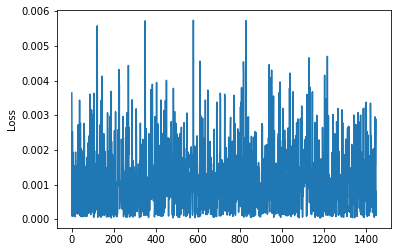

Train: 1449it [12:53,  1.78it/s, epoch=11, loss=0.00131]                          
valid:   0%|          | 0/73 [00:00<?, ?it/s]
valid: 74it [13:11, 10.69s/it]                        
Train: 1449it [26:03,  1.08s/it, epoch=10, loss=0.00119]
valid:   1%|▏         | 1/73 [00:00<00:15,  4.75it/s]

validating .... 


valid: 100%|██████████| 73/73 [00:12<00:00,  5.64it/s]2021-03-05 07:21:23.31 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /content/drive/MyDrive/colab_files/Publication_v1/sensitive/sensitive_model_v1/model]


y_test (1174, 19)
y_test
 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]]
y_pred_tag (1174, 19)
y_pred_tag
 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]]
f1 type macro value is 0.66
f1 type weighted value is 0.67
macro 0.6576851784877064
Epochs done: 12. Valid macro: 0.65

Train:   0%|          | 0/1448 [00:00<?, ?it/s]

New best score. Saving model.


Train: 100%|█████████▉| 1447/1448 [12:49<00:00,  1.89it/s, epoch=12, loss=0.00119]

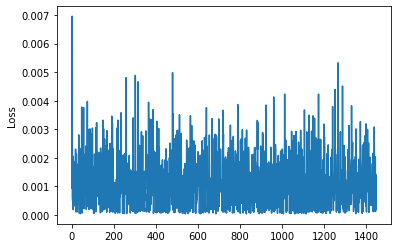

Train: 1449it [12:50,  1.79it/s, epoch=12, loss=0.00118]                          
valid:   0%|          | 0/73 [00:00<?, ?it/s]
valid: 74it [13:08, 10.66s/it]                        
Train: 1449it [26:02,  1.08s/it, epoch=11, loss=0.00131]
valid:   1%|▏         | 1/73 [00:00<00:15,  4.74it/s]

validating .... 


valid: 100%|██████████| 73/73 [00:12<00:00,  5.63it/s]2021-03-05 07:34:31.897 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /content/drive/MyDrive/colab_files/Publication_v1/sensitive/sensitive_model_v1/model]


y_test (1174, 19)
y_test
 [[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]]
y_pred_tag (1174, 19)
y_pred_tag
 [[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0]]
f1 type macro value is 0.67
f1 type weighted value is 0.68
macro 0.6669910732591953
Epochs done: 13. Valid macro: 0.66

Train:   0%|          | 0/1448 [00:00<?, ?it/s]

New best score. Saving model.


Train: 100%|█████████▉| 1447/1448 [12:52<00:00,  1.88it/s, epoch=13, loss=0.00102]

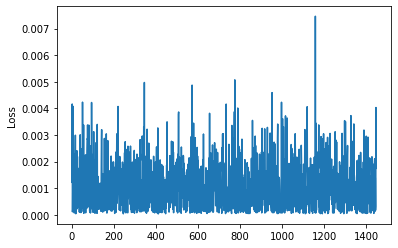

Train: 1449it [12:53,  1.76it/s, epoch=13, loss=0.00104]                          
valid:   0%|          | 0/73 [00:00<?, ?it/s]
valid: 74it [13:11, 10.69s/it]                        
Train: 1449it [26:01,  1.08s/it, epoch=12, loss=0.00118]
valid:   1%|▏         | 1/73 [00:00<00:15,  4.58it/s]

validating .... 


Train:   0%|          | 0/1448 [00:00<?, ?it/s]

y_test (1174, 19)
y_test
 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0]]
y_pred_tag (1174, 19)
y_pred_tag
 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0]]
f1 type macro value is 0.66
f1 type weighted value is 0.68
macro 0.664164055031494
Epochs done: 14. Valid macro: 0.664

Train: 100%|█████████▉| 1447/1448 [12:52<00:00,  1.87it/s, epoch=14, loss=0.00111]

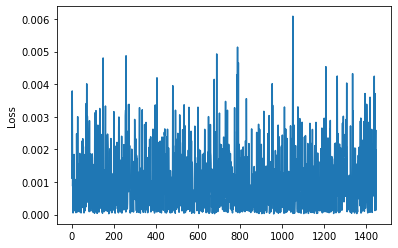

Train: 1449it [12:54,  1.76it/s, epoch=14, loss=0.00112]                          
valid:   0%|          | 0/73 [00:00<?, ?it/s]
valid: 74it [13:07, 10.64s/it]                        
Train: 1449it [26:00,  1.08s/it, epoch=13, loss=0.00104]
valid:   1%|▏         | 1/73 [00:00<00:15,  4.56it/s]

validating .... 


Train:   0%|          | 0/1448 [00:00<?, ?it/s]

y_test (1174, 19)
y_test
 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]]
y_pred_tag (1174, 19)
y_pred_tag
 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]]
f1 type macro value is 0.66
f1 type weighted value is 0.67
macro 0.6552883910793952
Epochs done: 15. Valid macro: 0.65

Train: 100%|█████████▉| 1447/1448 [12:52<00:00,  1.88it/s, epoch=15, loss=0.00111]

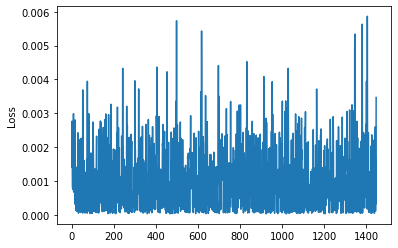

Train: 1449it [12:54,  1.78it/s, epoch=15, loss=0.00108]                          
valid:   0%|          | 0/73 [00:00<?, ?it/s]
valid: 74it [13:07, 10.64s/it]                        
Train: 1449it [26:01,  1.08s/it, epoch=14, loss=0.00112]
valid:   1%|▏         | 1/73 [00:00<00:13,  5.14it/s]

validating .... 


Train:   0%|          | 0/1448 [00:00<?, ?it/s]

y_test (1174, 19)
y_test
 [[1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0]
 [1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]]
y_pred_tag (1174, 19)
y_pred_tag
 [[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]]
f1 type macro value is 0.64
f1 type weighted value is 0.67
macro 0.6442920316606507
Epochs done: 16. Valid macro: 0.64

Train: 100%|█████████▉| 1447/1448 [12:51<00:00,  1.87it/s, epoch=16, loss=0.00107]

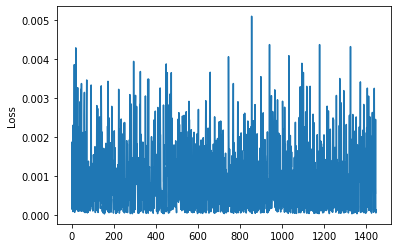

Train: 1449it [12:52,  1.76it/s, epoch=16, loss=0.00105]                          
valid:   0%|          | 0/73 [00:00<?, ?it/s]
valid: 74it [13:05, 10.61s/it]                        
Train: 1449it [25:59,  1.08s/it, epoch=15, loss=0.00108]
valid:   1%|▏         | 1/73 [00:00<00:15,  4.80it/s]

validating .... 


Train:   0%|          | 0/1448 [00:00<?, ?it/s]

y_test (1174, 19)
y_test
 [[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]]
y_pred_tag (1174, 19)
y_pred_tag
 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]]
f1 type macro value is 0.65
f1 type weighted value is 0.67
macro 0.6468384187239498
Epochs done: 17. Valid macro: 0.64

Train:  69%|██████▊   | 993/1448 [08:49<04:01,  1.89it/s, epoch=17, loss=0.00113]

In [ ]:
best_score = 0
patience = 8
impatience = 0
BATCH_SIZE = 16

DF_IN_USE = df
plot_every = int(len(DF_IN_USE)/BATCH_SIZE)

# let's train for 3 epochs
for ep in range(30):
  
    nbatches = 0
    # for instance in list(tqdm._instances):
    #   tqdm._decr_instances(instance)
    progress_bar = tqdm(total=int(len(DF_IN_USE)/BATCH_SIZE), desc='Train')
    train_loss = []
    for x, y in iterator.gen_batches(batch_size=BATCH_SIZE, 
                                     data_type="train", shuffle=True):
        x_feat = bert_preprocessor(x)
        y_onehot = one_hotter(vocab(y))
        loss_dict = bert_classifier.train_on_batch(x_feat, y_onehot)
        train_loss.append(loss_dict['loss'])
        nbatches += 1
  
          
        if nbatches%plot_every == 0:
          plt.plot(train_loss)
          plt.ylabel('Loss')
          plt.show() 

        progress_bar.set_postfix(epoch = ep,loss = np.mean(train_loss[-100:]))     
        progress_bar.update()

    
    y_valid_trues = []
    y_valid_preds = []
    progress_bar_valid = tqdm(total=int(len(df_val)/BATCH_SIZE), desc='valid')
    for instance in list(tqdm._instances):
          tqdm._decr_instances(instance)
    print("validating .... ")
    for x, y in iterator.gen_batches(batch_size=BATCH_SIZE, 
                                        data_type="valid", shuffle=True):
            y_valid_pred = bert_classifier(bert_preprocessor(x))
            y_valid_preds.extend(y_valid_pred)

            y_valid_trues.extend(y)
            progress_bar_valid.update()
    
   
    score = get_metrics(y_valid_trues, y_valid_preds)
    print("macro", score)


    print("Epochs done: {}. Valid macro: {}".format(ep + 1, score))
    if score > best_score:
        best_model = bert_classifier
        bert_classifier.save()
        print("New best score. Saving model.")
        best_score = score    
        impatience = 0
    else:
        impatience += 1
        if impatience == patience:
            print("Out of patience. Stop training.")
            break


# Final validations

In [29]:
BATCH_SIZE = 16
y_valid_trues = []
y_valid_preds = []
progress_bar_valid = tqdm(total=int(len(df_val)/BATCH_SIZE), desc='valid')
for instance in list(tqdm._instances):
      tqdm._decr_instances(instance)
print("validating .... ")
for x, y in iterator.gen_batches(batch_size=BATCH_SIZE, 
                                    data_type="test", shuffle=True):
        y_valid_pred = bert_classifier(bert_preprocessor(x))#best
        y_valid_preds.extend(y_valid_pred)

        y_valid_trues.extend(y)
        progress_bar_valid.update()


score = get_metrics(y_valid_trues, y_valid_preds)

valid:   0%|          | 0/73 [00:18<?, ?it/s]


validating .... 


valid: 83it [27:21, 17.56s/it]

y_test (1322, 19)
y_test
 [[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0]
 [0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]]
y_pred_tag (1322, 19)
y_pred_tag
 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
f1 type macro value is 0.64
f1 type weighted value is 0.66


In [30]:
topic2count_dict = {}
for col in list(df_val.columns)[1:]:
    cnt = sum(df_val[col])
    topic2count_dict[col] = cnt
topic2count_dict['none'] = 'no_count'

In [31]:
score = get_metrics(y_valid_trues, y_valid_preds, for_classifier = False)

y_test (1322, 19)
y_test
 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]]
y_pred_tag (1322, 19)
y_pred_tag
 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]]
f1 type macro value is 0.64
f1 type weighted value is 0.66


In [32]:
score

array([0.53535354, 0.39285714, 0.77922078, 0.76923077, 0.62569832,
       0.68456376, 0.62686567, 0.46153846, 0.48351648, 0.84644195,
       0.75897436, 0.78362573, 0.65151515, 0.68666667, 0.8447205 ,
       0.61333333, 0.60638298, 0.44280443, 0.65517241])

In [33]:
df_classes = pd.DataFrame({'class':topics_list,'f1':score})

In [34]:
def get_count(topic):
  return topic2count_dict[topic]
df_classes['validation_count'] = df_classes['class'].apply(get_count)

In [35]:
df_classes.head(100)

,class,f1,validation_count
0,offline_crime,0.535354,93
1,online_crime,0.392857,28
2,drugs,0.779221,64
3,gambling,0.769231,3
4,pornography,0.625698,141
5,prostitution,0.684564,59
6,slavery,0.626866,23
7,suicide,0.461538,4
8,terrorism,0.483516,28
9,weapons,0.846442,128
